In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
pd.set_option('max_columns', 150)
sns.set_style('darkgrid')

color = sns.color_palette()
destination_data = '/content/drive/MyDrive/Thesis Data/prepared_data/'

# Final dataset Loading

In [4]:
final_dataset_df = pd.read_csv(destination_data+'Final_data.csv')

#Memory Management 

In [5]:
#Method for memory reduction
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [6]:
final_dataset_df = reduce_memory(final_dataset_df)

Memory usage of properties dataframe is : 13513.215370178223  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  2311.4711513519287  MB
This is  17.105263906716253 % of the initial size


# Data Overview

In [7]:
final_dataset_df.shape

(8474661, 209)

In [8]:
final_dataset_df.head(10)

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered,product_avg_add_to_cart_order,product_orders_total_count,product_reorder_total_count,product_reorder_percentage,prod_order_first_time_total_cnt,prod_order_second_time_total_cnt,product_is_organic,product_vs_unique_users,second_time_purchased_percent,aisle_avg_add_to_cart_order,aisle_std_add_to_cart_order,aisle_orders_total_count,aisle_reorder_total_count,aisle_reorder_percentage,aisle_vs_unique_users,department_avg_add_to_cart_order,department_std_add_to_cart_order,department_orders_total_count,department_reorder_total_count,department_reorder_percentage,department_vs_unique_users,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,department_frozen,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,aisle_baking ingredients,aisle_baking supplies decor,aisle_beauty,aisle_beers coolers,aisle_body lotions soap,aisle_bread,aisle_breakfast bakery,aisle_breakfast bars pastries,aisle_bulk dried fruits vegetables,aisle_bulk grains rice dried goods,aisle_buns rolls,aisle_butter,aisle_candy chocolate,aisle_canned fruit applesauce,...,aisle_laundry,aisle_lunch meat,aisle_marinades meat preparation,aisle_meat counter,aisle_milk,aisle_mint gum,aisle_missing,aisle_more household,aisle_muscles joints pain relief,aisle_nuts seeds dried fruit,aisle_oils vinegars,aisle_oral hygiene,aisle_other,aisle_other creams cheeses,aisle_packaged cheese,aisle_packaged meat,aisle_packaged poultry,aisle_packaged produce,aisle_packaged seafood,aisle_packaged vegetables fruits,aisle_paper goods,aisle_pasta sauce,aisle_pickled goods olives,aisle_plates bowls cups flatware,aisle_popcorn jerky,aisle_poultry counter,aisle_prepared meals,aisle_prepared soups salads,aisle_preserved dips spreads,aisle_protein meal replacements,aisle_red wines,aisle_refrigerated,aisle_refrigerated pudding desserts,aisle_salad dressing toppings,aisle_seafood counter,aisle_shave needs,aisle_skin care,aisle_soap,aisle_soft drinks,aisle_soup broth bouillon,aisle_soy lactosefree,aisle_specialty cheeses,aisle_specialty wines champagnes,aisle_spices seasonings,aisle_spirits,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,user_purchased_avg_dow,user_purchased_std_dow,user_avg_order_hour_of_day,user_std_order_hour_of_day,user_avg_days_since_prior_order,user_std_days_since_prior_order,total_order_by_user,total_product_purchased_by_user,total_unique_product_purchased_by_user,total_product_reordered_by_user,product_reorder_propotion_by_user,user_average_order_size,user_reorder_items_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,1,196,10.0,9.0,1.400391,18.296875,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0,3.722656,35791,27791.0,0.776367,8000,4660,0,8000,0.582520,6.453125,6.449219,357537,228406.0,0.638672,63506,6.976562,6.710938,2690129,1757892.0,0.653320,172795,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.644531,1.255859,10.539062,3.5,19.140625,9.640625,10,59,18,41.0,0.694824,5.898438,0.706055,6,6,9,0.666504,1.0,0.666504,1.0
1,1,10258,9.0,8.0,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,4.0,8.0,14.0,1.0,4.277344,

In [9]:
# verifying which all feature is having null values.
round(final_dataset_df.isnull().sum(axis=0)/(final_dataset_df.shape[0])*100).sort_values(ascending=False)

order_diff                        0.0
aisle_food storage                0.0
aisle_canned jarred vegetables    0.0
aisle_canned fruit applesauce     0.0
aisle_candy chocolate             0.0
                                 ... 
aisle_lunch meat                  0.0
aisle_laundry                     0.0
aisle_latino foods                0.0
aisle_kosher foods                0.0
user_id                           0.0
Length: 209, dtype: float64

# Eliminating variables

In [10]:
final_dataset_df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [11]:
final_dataset_df.shape

(8474661, 207)

# Outlier Treatment 

In [46]:
final_dataset_df.describe([.25,.50,.75,.99])

,total_product_orders_by_user,total_product_reorders_by_user,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered,product_avg_add_to_cart_order,product_orders_total_count,product_reorder_total_count,product_reorder_percentage,prod_order_first_time_total_cnt,prod_order_second_time_total_cnt,product_is_organic,product_vs_unique_users,second_time_purchased_percent,aisle_avg_add_to_cart_order,aisle_std_add_to_cart_order,aisle_orders_total_count,aisle_reorder_total_count,aisle_reorder_percentage,aisle_vs_unique_users,department_avg_add_to_cart_order,department_std_add_to_cart_order,department_orders_total_count,department_reorder_total_count,department_reorder_percentage,department_vs_unique_users,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,department_frozen,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks,aisle_asian foods,aisle_baby accessories,aisle_baby bath body care,aisle_baby food formula,aisle_bakery desserts,aisle_baking ingredients,aisle_baking supplies decor,aisle_beauty,aisle_beers coolers,aisle_body lotions soap,aisle_bread,aisle_breakfast bakery,aisle_breakfast bars pastries,aisle_bulk dried fruits vegetables,aisle_bulk grains rice dried goods,aisle_buns rolls,aisle_butter,aisle_candy chocolate,aisle_canned fruit applesauce,aisle_canned jarred vegetables,aisle_canned meals beans,...,aisle_laundry,aisle_lunch meat,aisle_marinades meat preparation,aisle_meat counter,aisle_milk,aisle_mint gum,aisle_missing,aisle_more household,aisle_muscles joints pain relief,aisle_nuts seeds dried fruit,aisle_oils vinegars,aisle_oral hygiene,aisle_other,aisle_other creams cheeses,aisle_packaged cheese,aisle_packaged meat,aisle_packaged poultry,aisle_packaged produce,aisle_packaged seafood,aisle_packaged vegetables fruits,aisle_paper goods,aisle_pasta sauce,aisle_pickled goods olives,aisle_plates bowls cups flatware,aisle_popcorn jerky,aisle_poultry counter,aisle_prepared meals,aisle_prepared soups salads,aisle_preserved dips spreads,aisle_protein meal replacements,aisle_red wines,aisle_refrigerated,aisle_refrigerated pudding desserts,aisle_salad dressing toppings,aisle_seafood counter,aisle_shave needs,aisle_skin care,aisle_soap,aisle_soft drinks,aisle_soup broth bouillon,aisle_soy lactosefree,aisle_specialty cheeses,aisle_specialty wines champagnes,aisle_spices seasonings,aisle_spirits,aisle_spreads,aisle_tea,aisle_tofu meat alternatives,aisle_tortillas flat bread,aisle_trail mix snack mix,aisle_trash bags liners,aisle_vitamins supplements,aisle_water seltzer sparkling water,aisle_white wines,aisle_yogurt,user_purchased_avg_dow,user_purchased_std_dow,user_avg_order_hour_of_day,user_std_order_hour_of_day,user_avg_days_since_prior_order,user_std_days_since_prior_order,total_order_by_user,total_product_purchased_by_user,total_unique_product_purchased_by_user,total_product_reordered_by_user,product_reorder_propotion_by_user,user_average_order_size,user_reorder_items_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
count,8474661.0,8474661.0,8474661.0,8474661.0,8474661.0,8474661.0,8474661.0,8474661.0,8474661.0,8474661.0,8474661.0,8474661.0,8474661.0,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8474661.0,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8474661.000,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8474661.00,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,8.474661e+06,

In [47]:
# num_col = list(final_dataset_df.dtypes[final_dataset_df.dtypes !='object'].index)

# def drop_outliers(x):
#     for col in num_col:
#         Q1 = x[col].quantile(.15)
#         Q3 = x[col].quantile(.99)
#         IQR = Q3-Q1
#         x =  x[(x[col] >= (Q1-(1.5*IQR))) & (x[col] <= (Q3+(1.5*IQR)))] 
    
#     return x   

# final_dataset_df = drop_outliers(final_dataset_df)

In [12]:
final_dataset_df.shape

(8474661, 207)

# Preparing  Small dataset for model building (As the intra is Limited)

In [13]:
final_dataset_df = final_dataset_df.head(100000)

#Split Dataset into Train and Test dataset

In [14]:
#putting features variables in X
X = final_dataset_df.drop(['reordered'], axis=1)

#putting response variables in Y
y = final_dataset_df['reordered']    

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.25,random_state=100)

In [15]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70000, 206) (70000,)
(25000, 206) (25000,)


#Scaling Data

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [17]:
# fitting and transforming the scaler on train
X_train = scaler.fit_transform(X_train)
# transforming the train using the already fit scaler
X_test = scaler.transform(X_test)

#Class Imbalancing

In [18]:
print("Before Sampling,reordered =  '1': {}".format(sum(y_train==1)))
print("Before Sampling,reordered = '0': {} ".format(sum(y_train==0)))
print("Before Sampling,reordered  rate : {}% ".format(round(sum(y_train==1)/len(y_train)*100,2)))

Before Sampling,reordered =  '1': 7224
Before Sampling,reordered = '0': 62776 
Before Sampling,reordered  rate : 10.32% 


In [19]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [20]:
print('After Sampling, train_X: {}'.format(X_train_res.shape))
print('After Sampling, train_y: {} \n'.format(y_train_res.shape))

After Sampling, train_X: (125552, 206)
After Sampling, train_y: (125552,) 



In [21]:
print("After Sampling, reordered= '1': {}".format(sum(y_train_res==1)))
print("After Sampling,reordered= '0': {}".format(sum(y_train_res==0)))
print("After Sampling, reordered rate : {}% \n".format(round(sum(y_train_res==1)/len(y_train_res)*100,2)))

After Sampling, reordered= '1': 62776
After Sampling,reordered= '0': 62776
After Sampling, reordered rate : 50.0% 



# Common Features for Model building

In [22]:
def getModelMetrics(actual_reordered=False,pred_reordered=False):

    confusion = metrics.confusion_matrix(actual_reordered, pred_reordered)

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    print("Roc_auc_score : {}".format(metrics.roc_auc_score(actual_reordered,pred_reordered)))
    print('Sensitivity/Recall : {}'.format(TP / float(TP+FN)))
    print('Specificity: {}'.format(TN / float(TN+FP)))
    print('False Positive Rate: {}'.format(FP/ float(TN+FP)))
    print('Positive predictive value: {}'.format(TP / float(TP+FP)))
    print('Negative Predictive value: {}'.format(TN / float(TN+ FN)))
    print('sklearn precision score value: {}'.format(metrics.precision_score(actual_reordered, pred_reordered )))

In [23]:
def model_evaluation(y_pred_final):
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        y_pred_final[i]= y_pred_final.reordered_Prob.map( lambda x: 1 if x > i else 0)
    display(y_pred_final.head())

In [24]:
def final_model(y_pred_final):
    confusion = metrics.confusion_matrix(y_pred_final.reordered, y_pred_final.final_predicted)
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    display(confusion)
        
    print('Sensitivity/Recall : {}'.format(TP / float(TP+FN)))
    print('Specificity: {}'.format(TN / float(TN+FP)))
    print('Accuracy : ' , metrics.accuracy_score(y_pred_final.reordered, y_pred_final.final_predicted))

In [25]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

# Random Forest Model for Top Feature Selection

In [62]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

In [63]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [8,10,12],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [12,15, 20]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [64]:
# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 39.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              random_state=None, verbose=0,
                                   

In [65]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8403291927314039 using {'criterion': 'entropy', 'max_depth': 12, 'max_features': 20, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 100}


In [66]:
rf_final = RandomForestClassifier(criterion= 'entropy',
                            max_depth=12,
                            max_features=20,
                            min_samples_leaf=100,
                            min_samples_split=200,
                            n_estimators=100,
                            random_state=None)

In [67]:
rf_final.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=12, max_features=20,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [68]:
# predict
predictions = rf_final.predict(X_test)

In [69]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix

In [70]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90     22396
         1.0       0.32      0.61      0.42      2604

    accuracy                           0.83     25000
   macro avg       0.64      0.73      0.66     25000
weighted avg       0.88      0.83      0.85     25000



In [71]:
getModelMetrics(actual_reordered=y_test,pred_reordered=predictions)

Roc_auc_score : 0.7317909317798412
Sensitivity/Recall : 0.6121351766513057
Specificity: 0.8514466869083765
False Positive Rate: 0.1485533130916235
Positive predictive value: 0.3239179028652713
Negative Predictive value: 0.9496986901738135
sklearn precision score value: 0.3239179028652713


In [72]:
cut_off_prob = 0.5
# predict
pred_probs= rf_final.predict_proba(X_test)[:,1]
y_df= pd.DataFrame({'reordered':y_test, 'reordered_Prob':pred_probs})
# Creating new column 'predicted' with 1 if reordered_Prob>0.5 else 0
y_df['final_predicted'] = y_df.reordered_Prob.map( lambda x: 1 if x > cut_off_prob else 0)

In [73]:
# confusion matrix
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[19069  3327]
 [ 1010  1594]]
0.82652


     prob  accuracy     sensi     speci
0.0   0.0   0.10416  1.000000  0.000000
0.1   0.1   0.27820  0.979647  0.196642
0.2   0.2   0.47168  0.922811  0.419227
0.3   0.3   0.62184  0.845238  0.595865
0.4   0.4   0.74628  0.745392  0.746383
0.5   0.5   0.82652  0.612135  0.851447
0.6   0.6   0.87012  0.468510  0.916816
0.7   0.7   0.89060  0.337174  0.954947
0.8   0.8   0.90132  0.191628  0.983836
0.9   0.9   0.89896  0.050691  0.997589


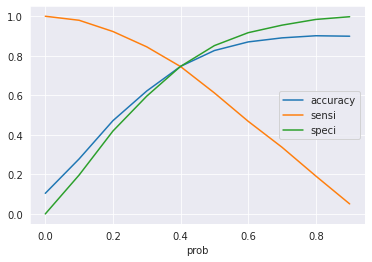

In [74]:
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        y_df[i] = y_df.reordered_Prob.map( lambda x: 1 if x > i else 0)
    #print(df.head())
    
    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    from sklearn.metrics import confusion_matrix
    
    # TP = confusion[1,1] # true positive 
    # TN = confusion[0,0] # true negatives
    # FP = confusion[0,1] # false positives
    # FN = confusion[1,0] # false negatives
    
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(y_df.reordered, y_df[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    print(cutoff_df)
    # Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()

In [75]:
model_evaluation(y_df)

,reordered,reordered_Prob,final_predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
22422,0.0,0.453672,0,1,1,1,1,1,0,0,0,0,0
25747,0.0,0.129163,0,1,1,0,0,0,0,0,0,0,0
13795,0.0,0.219886,0,1,1,1,0,0,0,0,0,0,0
68724,0.0,0.202186,0,1,1,1,0,0,0,0,0,0,0
38923,0.0,0.111209,0,1,1,0,0,0,0,0,0,0,0


In [76]:
final_model(y_df)

array([[19069,  3327],
       [ 1010,  1594]])

Sensitivity/Recall : 0.6121351766513057
Specificity: 0.8514466869083765
Accuracy :  0.82652


In [77]:
rf_final.feature_importances_

array([1.41119942e-01, 1.53864379e-01, 7.22438302e-03, 4.06505249e-02,
       3.07719718e-02, 6.09145152e-02, 6.29919416e-02, 2.48646021e-02,
       2.08522618e-02, 1.67797238e-02, 6.45580689e-03, 1.83665176e-02,
       5.06628603e-03, 1.00370152e-02, 8.99767845e-03, 1.81502612e-02,
       5.77809712e-03, 7.93975405e-03, 0.00000000e+00, 4.49095819e-03,
       1.57479138e-02, 3.07405800e-03, 1.97289874e-03, 2.35440381e-03,
       3.34536126e-03, 5.21422995e-03, 2.12139732e-03, 1.30118764e-03,
       1.85544421e-03, 9.63225188e-04, 1.17583037e-03, 3.40914492e-03,
       1.04326440e-03, 0.00000000e+00, 0.00000000e+00, 3.49725353e-05,
       1.72939705e-05, 0.00000000e+00, 2.38076501e-05, 1.18914891e-04,
       1.08113385e-05, 1.27159952e-05, 1.63271943e-05, 1.25060025e-05,
       0.00000000e+00, 1.59564505e-05, 0.00000000e+00, 0.00000000e+00,
       6.11295578e-04, 1.18866681e-05, 0.00000000e+00, 1.50630450e-04,
       2.64045308e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

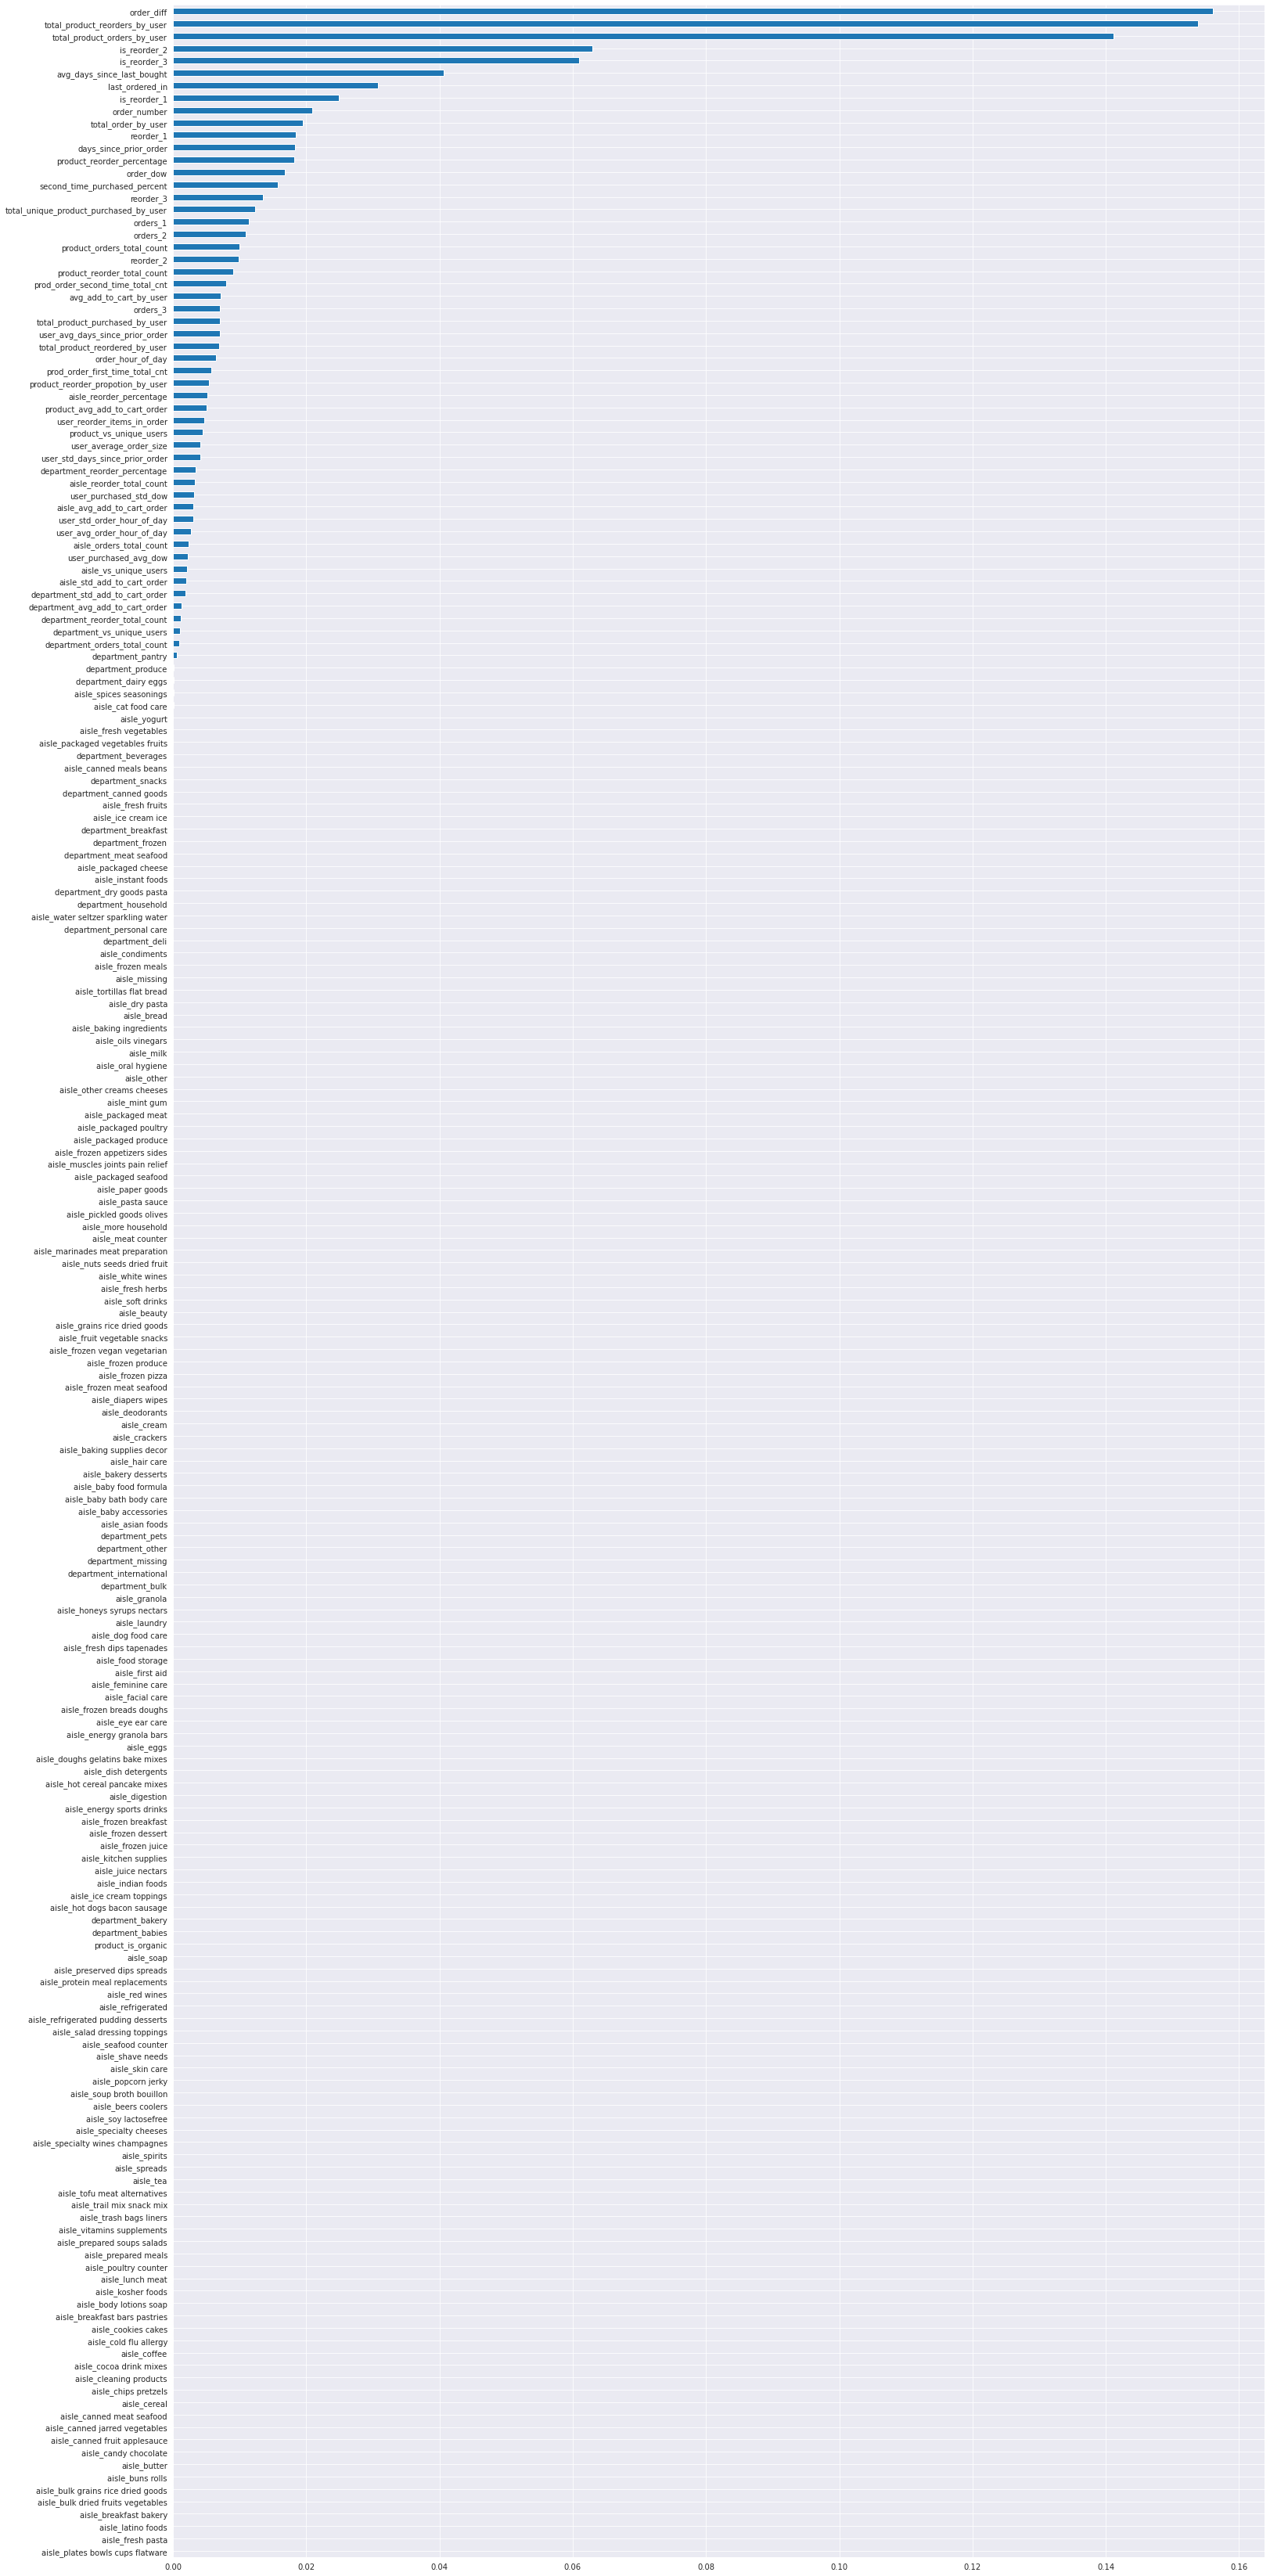

In [78]:
plt.figure(figsize=(25,60))
feat_importances = pd.Series(rf_final.feature_importances_, index=X.columns)
feat_importances.nlargest(len(X.columns)).sort_values().plot(kind='barh', align='center')

In [79]:
feat_importances.sort_values(ascending=False)

order_diff                        0.156016
total_product_reorders_by_user    0.153864
total_product_orders_by_user      0.141120
is_reorder_2                      0.062992
is_reorder_3                      0.060915
                                    ...   
aisle_facial care                 0.000000
aisle_feminine care               0.000000
aisle_first aid                   0.000000
aisle_food storage                0.000000
aisle_fresh dips tapenades        0.000000
Length: 206, dtype: float64

# XGBoost Model for Top Feature Selection

In [26]:
# Importing random forest classifier from sklearn library
from xgboost.sklearn import XGBClassifier 

In [27]:
# Create the parameter grid based on the results of random search 
xgb_clf=XGBClassifier(n_estimators=100)
xgb_clf.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [28]:
# Fit the grid search to the data
from sklearn.model_selection import RandomizedSearchCV
# Fit Extreme Gradient boosting classifier
param_grid = {'max_depth': [5,6,7,8], 'gamma': [0.01,0.001,0.001],'min_child_weight':[1,5,10], 
              'learning_rate': [0.05,0.1, 0.2, 0.3], 'n_estimators':[5,10,20,100,200,300]}


xgb_random = RandomizedSearchCV(estimator = xgb_clf, param_distributions = param_grid, n_iter = 100, cv = 3, 
                               verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train_res, y_train_res)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 27.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_i

In [29]:
# printing the optimal accuracy score and hyperparameters
print("Best Parameters are:",xgb_random.best_params_)

Best Parameters are: {'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.01}


In [30]:
# Model building with best hyperparameters
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators = 300, min_child_weight= 5, max_depth = 8, learning_rate = 0.1, gamma = 0.01)
xgb_clf.fit(X_train_res, y_train_res)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.01,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [31]:
y_pred_xgb = xgb_clf.predict(X_test)

In [32]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix

In [33]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95     22396
         1.0       0.57      0.27      0.37      2604

    accuracy                           0.90     25000
   macro avg       0.75      0.62      0.66     25000
weighted avg       0.88      0.90      0.89     25000



In [34]:
getModelMetrics(actual_reordered=y_test,pred_reordered=y_pred_xgb)

Roc_auc_score : 0.6237951820450711
Sensitivity/Recall : 0.27112135176651303
Specificity: 0.9764690123236293
False Positive Rate: 0.023530987676370782
Positive predictive value: 0.5725871857258719
Negative Predictive value: 0.9201413724912694
sklearn precision score value: 0.5725871857258719


In [35]:
cut_off_prob = 0.5
# predict
pred_probs_xgboost= xgb_clf.predict_proba(X_test)[:,1]
y_df_xgb= pd.DataFrame({'reordered':y_test, 'reordered_Prob':pred_probs_xgboost})
# Creating new column 'predicted' with 1 if reordered_Prob>0.5 else 0
y_df_xgb['final_predicted'] = y_df_xgb.reordered_Prob.map( lambda x: 1 if x > cut_off_prob else 0)

In [36]:
# confusion matrix
print(confusion_matrix(y_test,y_pred_xgb))
print(accuracy_score(y_test,y_pred_xgb))

[[21869   527]
 [ 1898   706]]
0.903


     prob  accuracy     sensi     speci
0.0   0.0   0.10416  1.000000  0.000000
0.1   0.1   0.75700  0.762289  0.756385
0.2   0.2   0.85232  0.581029  0.883863
0.3   0.3   0.88360  0.450077  0.934006
0.4   0.4   0.89636  0.350998  0.959770
0.5   0.5   0.90300  0.271121  0.976469
0.6   0.6   0.90372  0.192012  0.986471
0.7   0.7   0.90416  0.137097  0.993347
0.8   0.8   0.90092  0.074501  0.997008
0.9   0.9   0.89780  0.024962  0.999286


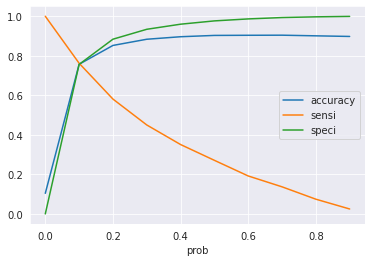

In [38]:
    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        y_df_xgb[i] = y_df_xgb.reordered_Prob.map( lambda x: 1 if x > i else 0)
    
    # Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
    cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
    from sklearn.metrics import confusion_matrix
    
    # TP = confusion[1,1] # true positive 
    # TN = confusion[0,0] # true negatives
    # FP = confusion[0,1] # false positives
    # FN = confusion[1,0] # false negatives
    
    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(y_df_xgb.reordered, y_df_xgb[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1
        
        speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
    print(cutoff_df)
    # Let's plot accuracy sensitivity and specificity for various probabilities.
    cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
    plt.show()

In [39]:
model_evaluation(y_df_xgb)

,reordered,reordered_Prob,final_predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
22422,0.0,0.022367,0,1,0,0,0,0,0,0,0,0,0
25747,0.0,0.032685,0,1,0,0,0,0,0,0,0,0,0
13795,0.0,0.051852,0,1,0,0,0,0,0,0,0,0,0
68724,0.0,0.021663,0,1,0,0,0,0,0,0,0,0,0
38923,0.0,0.011454,0,1,0,0,0,0,0,0,0,0,0


In [40]:
final_model(y_df_xgb)

array([[21869,   527],
       [ 1898,   706]])

Sensitivity/Recall : 0.27112135176651303
Specificity: 0.9764690123236293
Accuracy :  0.903


In [41]:
xgb_clf.feature_importances_

array([0.09977546, 0.        , 0.00316944, 0.0076715 , 0.005541  ,
       0.02250207, 0.03536554, 0.02081589, 0.00832953, 0.06284245,
       0.03271754, 0.01810938, 0.00284306, 0.00306728, 0.00501055,
       0.00446814, 0.00277379, 0.00347863, 0.        , 0.        ,
       0.00463128, 0.00346611, 0.00334193, 0.00393237, 0.00360469,
       0.00492279, 0.003192  , 0.00342134, 0.00300796, 0.00332255,
       0.0038555 , 0.00312489, 0.00298175, 0.        , 0.0032745 ,
       0.00504083, 0.00322669, 0.        , 0.00273765, 0.        ,
       0.00311378, 0.00706482, 0.00332999, 0.0026468 , 0.0029795 ,
       0.00183088, 0.00827475, 0.        , 0.0037793 , 0.        ,
       0.00846412, 0.        , 0.0043993 , 0.        , 0.        ,
       0.        , 0.01203195, 0.        , 0.00511039, 0.        ,
       0.        , 0.        , 0.        , 0.003666  , 0.00461085,
       0.00929555, 0.        , 0.        , 0.002968  , 0.00469461,
       0.00556046, 0.02298734, 0.00532885, 0.00414423, 0.00143

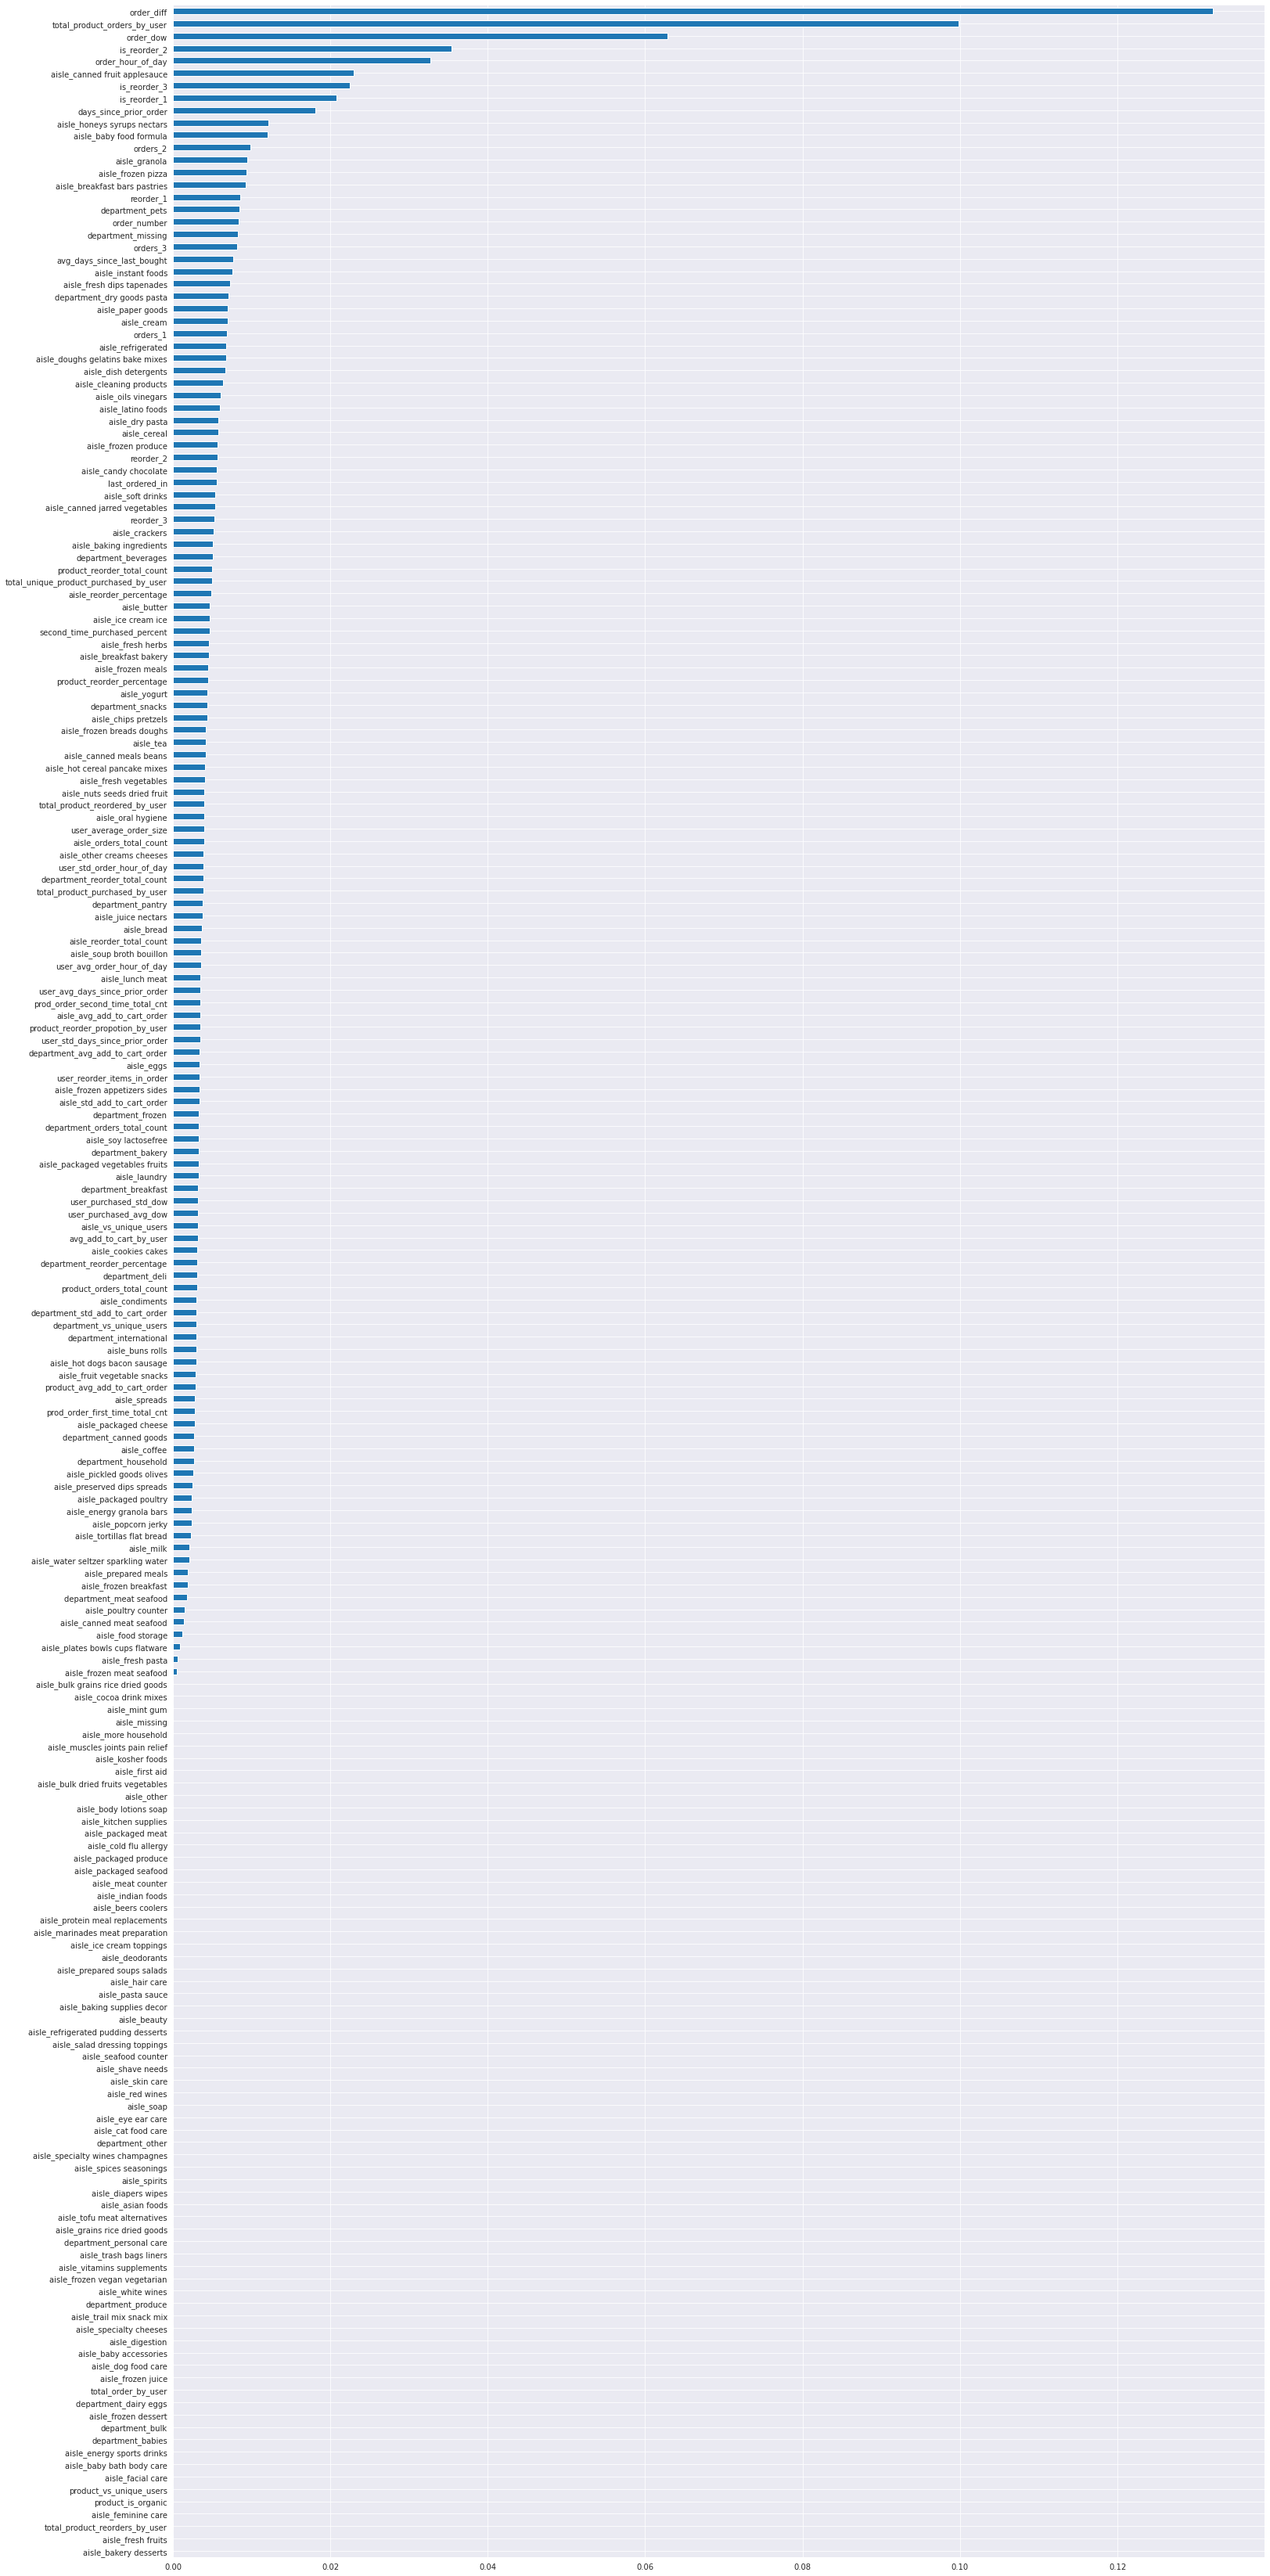

In [42]:
plt.figure(figsize=(25,60))
feat_importances_rgb = pd.Series(xgb_clf.feature_importances_, index=X.columns)
feat_importances_rgb.nlargest(len(X.columns)).sort_values().plot(kind='barh', align='center')

In [43]:
feat_importances_rgb.sort_values(ascending=False)

order_diff                      0.132077
total_product_orders_by_user    0.099775
order_dow                       0.062842
is_reorder_2                    0.035366
order_hour_of_day               0.032718
                                  ...   
aisle_first aid                 0.000000
aisle_tofu meat alternatives    0.000000
aisle_frozen dessert            0.000000
aisle_frozen juice              0.000000
aisle_fresh fruits              0.000000
Length: 206, dtype: float32